In [9]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

from ssd import SSD300, MultiboxLoss, BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

In [10]:
voc_classes = ['m1','m2','m3','m4','m5','m6','m7','m8','m9',
               'p1','p2','p3','p4','p5','p6','p7','p8','p9',
               's1','s2','s3','s4','s5','s6','s7','s8','s9',
               'e','s','w','n','haku','hatsu','chun']
NUM_CLASSES = len(voc_classes) + 1

In [17]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('checkpoints/weights.23-11.05.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

# 分類したい画像の選択

In [18]:
inputs = []
images = []

img_path = './test_image/m2_p1_s1_m1.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())

img_path = './test_image/2017-12-23T19:41:37:982652.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

In [19]:
preds = model.predict(inputs, batch_size=1, verbose=1)

2/2 [==============================] - 1s     


In [20]:
results = bbox_util.detection_out(preds)

/home/kawashima/ドキュメント/majan/ssd/ssd_utils.py:172: RuntimeWarning: overflow encountered in exp
  decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
/home/kawashima/ドキュメント/majan/ssd/ssd_utils.py:174: RuntimeWarning: overflow encountered in exp
  decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])


In [21]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

CPU times: user 5.95 s, sys: 124 ms, total: 6.07 s
Wall time: 1.61 s


/home/kawashima/ドキュメント/majan/ssd/ssd_utils.py:172: RuntimeWarning: overflow encountered in exp
  decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
/home/kawashima/ドキュメント/majan/ssd/ssd_utils.py:174: RuntimeWarning: overflow encountered in exp
  decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])


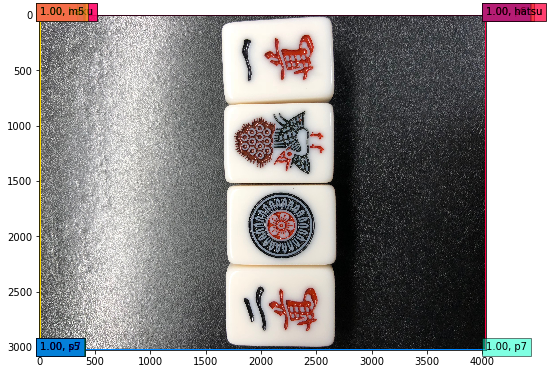

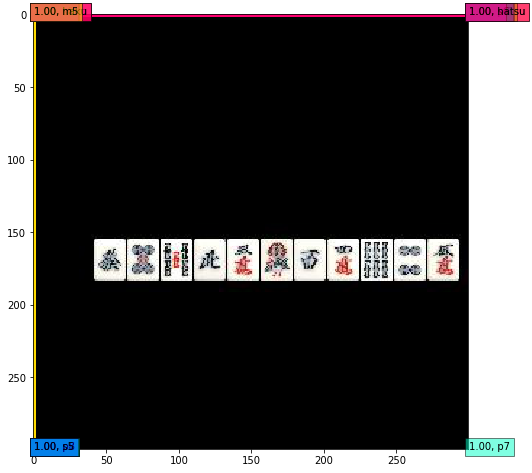

In [22]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()